In [1]:
%pip install captcha 
%pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
%pip install keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

In [3]:
import itertools
import pandas as pd
import os
import cv2
import numpy as np
from random import random, randint, choices

In [4]:
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

In [6]:
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        print('generating %d/%d' % (counter + 1, num_of_repetition))
        for i in itertools.permutations([str(c) for c in range(10)], num_of_letters):
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [5]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135


# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [6]:
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, 10))
                for i in range(NUM_OF_LETTERS):
                    label[i, int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [12]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 8 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [7]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 30240 (train=27189, test=3051)


In [9]:
x_train.shape

(27189, 25, 67, 1)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27189, 25, 67, 1)
(27189, 5, 10)
(3051, 25, 67, 1)
(3051, 5, 10)


In [11]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [12]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [13]:
input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
model = Model(inputs=input_layer, outputs=out)

In [ ]:
# Uncomment these if you want to load and continue an already trained network

# model_path = os.path.join(save_dir, model_name)
# model = keras.models.load_model(model_path)

In [14]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 67, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 67, 32)   832         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 33, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 33, 48)   38448       ['max_pooling2d[0][0]']          
                                                                                              

In [15]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [16]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [17]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/50
213/213 [==============================] - 120s 539ms/step - loss: 1.6886 - digit0_loss: 0.3382 - digit1_loss: 0.3378 - digit2_loss: 0.3375 - digit3_loss: 0.3377 - digit4_loss: 0.3375 - digit0_accuracy: 0.0989 - digit1_accuracy: 0.0966 - digit2_accuracy: 0.0987 - digit3_accuracy: 0.0975 - digit4_accuracy: 0.1002 - val_loss: 1.6294 - val_digit0_loss: 0.3255 - val_digit1_loss: 0.3263 - val_digit2_loss: 0.3261 - val_digit3_loss: 0.3258 - val_digit4_loss: 0.3257 - val_digit0_accuracy: 0.1026 - val_digit1_accuracy: 0.0865 - val_digit2_accuracy: 0.1055 - val_digit3_accuracy: 0.0937 - val_digit4_accuracy: 0.0980
Epoch 2/50
213/213 [==============================] - 100s 468ms/step - loss: 1.6380 - digit0_loss: 0.3273 - digit1_loss: 0.3277 - digit2_loss: 0.3278 - digit3_loss: 0.3275 - digit4_loss: 0.3277 - digit0_accuracy: 0.1033 - digit1_accuracy: 0.1009 - digit2_accuracy: 0.0997 - digit3_accuracy: 0.1022 - digit4_accuracy: 0.0995 - val_loss: 1.6221 - val_digit0_loss: 0.3213 - val_

213/213 [==============================] - 83s 391ms/step - loss: 0.1700 - digit0_loss: 0.0190 - digit1_loss: 0.0403 - digit2_loss: 0.0474 - digit3_loss: 0.0414 - digit4_loss: 0.0218 - digit0_accuracy: 0.9776 - digit1_accuracy: 0.9498 - digit2_accuracy: 0.9423 - digit3_accuracy: 0.9493 - digit4_accuracy: 0.9742 - val_loss: 0.1031 - val_digit0_loss: 0.0107 - val_digit1_loss: 0.0251 - val_digit2_loss: 0.0297 - val_digit3_loss: 0.0253 - val_digit4_loss: 0.0122 - val_digit0_accuracy: 0.9859 - val_digit1_accuracy: 0.9679 - val_digit2_accuracy: 0.9594 - val_digit3_accuracy: 0.9636 - val_digit4_accuracy: 0.9843
Epoch 15/50
213/213 [==============================] - 83s 391ms/step - loss: 0.1539 - digit0_loss: 0.0173 - digit1_loss: 0.0368 - digit2_loss: 0.0437 - digit3_loss: 0.0364 - digit4_loss: 0.0197 - digit0_accuracy: 0.9796 - digit1_accuracy: 0.9559 - digit2_accuracy: 0.9479 - digit3_accuracy: 0.9548 - digit4_accuracy: 0.9774 - val_loss: 0.0982 - val_digit0_loss: 0.0111 - val_digit1_loss:

213/213 [==============================] - 84s 393ms/step - loss: 0.0690 - digit0_loss: 0.0075 - digit1_loss: 0.0158 - digit2_loss: 0.0202 - digit3_loss: 0.0168 - digit4_loss: 0.0087 - digit0_accuracy: 0.9927 - digit1_accuracy: 0.9861 - digit2_accuracy: 0.9800 - digit3_accuracy: 0.9827 - digit4_accuracy: 0.9913 - val_loss: 0.0606 - val_digit0_loss: 0.0076 - val_digit1_loss: 0.0137 - val_digit2_loss: 0.0162 - val_digit3_loss: 0.0147 - val_digit4_loss: 0.0083 - val_digit0_accuracy: 0.9895 - val_digit1_accuracy: 0.9797 - val_digit2_accuracy: 0.9774 - val_digit3_accuracy: 0.9813 - val_digit4_accuracy: 0.9892
Epoch 28/50
213/213 [==============================] - 83s 391ms/step - loss: 0.0660 - digit0_loss: 0.0071 - digit1_loss: 0.0155 - digit2_loss: 0.0192 - digit3_loss: 0.0161 - digit4_loss: 0.0081 - digit0_accuracy: 0.9925 - digit1_accuracy: 0.9851 - digit2_accuracy: 0.9822 - digit3_accuracy: 0.9829 - digit4_accuracy: 0.9923 - val_loss: 0.0600 - val_digit0_loss: 0.0081 - val_digit1_loss:

213/213 [==============================] - 95s 446ms/step - loss: 0.0444 - digit0_loss: 0.0047 - digit1_loss: 0.0099 - digit2_loss: 0.0134 - digit3_loss: 0.0107 - digit4_loss: 0.0056 - digit0_accuracy: 0.9956 - digit1_accuracy: 0.9907 - digit2_accuracy: 0.9891 - digit3_accuracy: 0.9899 - digit4_accuracy: 0.9950 - val_loss: 0.0522 - val_digit0_loss: 0.0072 - val_digit1_loss: 0.0131 - val_digit2_loss: 0.0131 - val_digit3_loss: 0.0126 - val_digit4_loss: 0.0062 - val_digit0_accuracy: 0.9905 - val_digit1_accuracy: 0.9833 - val_digit2_accuracy: 0.9843 - val_digit3_accuracy: 0.9839 - val_digit4_accuracy: 0.9918
Epoch 41/50
213/213 [==============================] - 88s 411ms/step - loss: 0.0405 - digit0_loss: 0.0044 - digit1_loss: 0.0093 - digit2_loss: 0.0121 - digit3_loss: 0.0100 - digit4_loss: 0.0047 - digit0_accuracy: 0.9960 - digit1_accuracy: 0.9921 - digit2_accuracy: 0.9905 - digit3_accuracy: 0.9915 - digit4_accuracy: 0.9960 - val_loss: 0.0538 - val_digit0_loss: 0.0076 - val_digit1_loss:

In [18]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()



    # Plot training & validation loss values
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

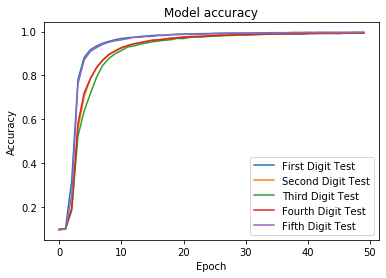

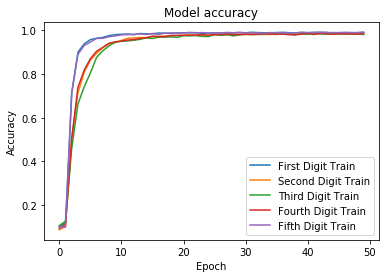

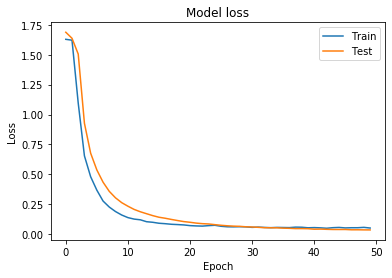

In [19]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [20]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/divya/Desktop/Project/saved_models/keras_cifar10_trained_model.h5 


In [21]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))

850/850 [==============================] - 21s 25ms/step - loss: 0.0029 - digit0_loss: 2.3934e-04 - digit1_loss: 6.4371e-04 - digit2_loss: 9.5531e-04 - digit3_loss: 7.1822e-04 - digit4_loss: 3.2198e-04 - digit0_accuracy: 0.9999 - digit1_accuracy: 0.9999 - digit2_accuracy: 0.9998 - digit3_accuracy: 0.9998 - digit4_accuracy: 0.9999
Train loss:     0.001087
Train accuracy: 99.93


In [22]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

96/96 [==============================] - 3s 27ms/step - loss: 0.0502 - digit0_loss: 0.0068 - digit1_loss: 0.0110 - digit2_loss: 0.0127 - digit3_loss: 0.0119 - digit4_loss: 0.0077 - digit0_accuracy: 0.9918 - digit1_accuracy: 0.9849 - digit2_accuracy: 0.9816 - digit3_accuracy: 0.9859 - digit4_accuracy: 0.9908
Test loss:     0.018524
Test accuracy: 93.67
